# Experiments with Synthetic Data

This notebooks reproduces the results of Section IV-B of the paper ["Learning Radio Environments by
Differentiable Ray Tracing"](https://arxiv.org/abs/2311.18558) by J. Hoydis, F. Ait Aoudia, S. Cammerer, F. Euchner, M. Nimier-David, S. ten Brink, and A. Keller, Dec. 2023.

The code is made available under the [NVIDIA License](https://github.com/NVlabs/diff-rt-calibration/blob/main/LICENSE.txt).

## Imports

In [1]:
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

%matplotlib widget
import matplotlib.pyplot as plt
import pickle
sys.path.append("../../sionna")
# Sionna imports
import sionna
from sionna.rt import load_scene, BackscatteringPattern
from sionna.rt.antenna import tr38901_pattern
from sionna.rt.utils import r_hat

# Import utility functions
sys.path.append('../code')
from utils import *
from trainable_antenna_pattern import TrainableAntennaPattern
from trainable_scattering_pattern import TrainableScatteringPattern
from trainable_materials import TrainableMaterials


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Configure Scene

In [2]:
# Load simple scene scene representation consisting of three objects
# floor, walls, and ceiling
scene = init_scene("inue_simple", use_tx_array=False)

# Place transmitter in the scene
place_transmitter_arrays(scene, tx_indices=2)

# Define the scattering pattern used by all materials
target_pattern = BackscatteringPattern(alpha_r=5, alpha_i=8, lambda_=0.8)

# Set material properties
scene.objects["floor"].radio_material = "itu_concrete"
scene.objects["floor"].radio_material.scattering_coefficient = 0.3
scene.objects["floor"].radio_material.xpd_coefficient = 0.2
scene.objects["floor"].radio_material.scattering_pattern = target_pattern

scene.objects["walls"].radio_material = "itu_plasterboard"
scene.objects["walls"].radio_material.scattering_coefficient = 0.5
scene.objects["walls"].radio_material.xpd_coefficient = 0.4
scene.objects["walls"].radio_material.scattering_pattern = target_pattern

scene.objects["ceiling"].radio_material = "itu_ceiling_board"
scene.objects["ceiling"].radio_material.scattering_coefficient = 0.8
scene.objects["ceiling"].radio_material.xpd_coefficient = 0.3
scene.objects["ceiling"].radio_material.scattering_pattern = target_pattern

# Store ground truth values values
ground_truth = {
    "floor" : {},
    "walls" : {},
    "ceiling" : {}
}

for obj in ground_truth:
    ground_truth[obj]["relative_permittivity"] = float(scene.objects[obj].radio_material.relative_permittivity)
    ground_truth[obj]["conductivity"] = float(scene.objects[obj].radio_material.conductivity)
    ground_truth[obj]["scattering_coefficient"] = float(scene.objects[obj].radio_material.scattering_coefficient)
    ground_truth[obj]["xpd_coefficient"] = float(scene.objects[obj].radio_material.xpd_coefficient)

    print("Object: ", obj.capitalize())
    print("Relative permittivity: ", ground_truth[obj]["relative_permittivity"])
    print("Conductivity: ", ground_truth[obj]["conductivity"])
    print("Scattering coefficient: ", ground_truth[obj]["scattering_coefficient"])
    print("XPD coefficient: ", ground_truth[obj]["xpd_coefficient"], "\n")

ground_truth["target_pattern"] = target_pattern


Object:  Floor
Relative permittivity:  5.239999771118164
Conductivity:  0.12137812376022339
Scattering coefficient:  0.30000001192092896
XPD coefficient:  0.20000000298023224 

Object:  Walls
Relative permittivity:  2.7300000190734863
Conductivity:  0.027119290083646774
Scattering coefficient:  0.5
XPD coefficient:  0.4000000059604645 

Object:  Ceiling
Relative permittivity:  1.4800000190734863
Conductivity:  0.004148791078478098
Scattering coefficient:  0.800000011920929
XPD coefficient:  0.30000001192092896 



## Generate synthetic dataset

In [3]:
# Set random seed
tf.random.set_seed(3)

# Load receiver positions
pos = np.load("../data/synthetic_positions.npy")

# Place receivers
instantiate_receivers(scene, len(pos))
set_receiver_positions(scene, pos)

# Trace paths
traced_paths = scene.trace_paths(max_depth=3,
                                 num_samples=1e5,
                                 los=True,
                                 reflection=True,
                                 diffraction=True,
                                 edge_diffraction=False,
                                 scattering=True,
                                 refraction=False,
                                 scat_keep_prob=1e-4)

# Print some information about the data
max_num_paths_spec = traced_paths[0].objects.shape[-1]
max_num_paths_diff = traced_paths[1].objects.shape[-1]
max_num_paths_scat = traced_paths[2].objects.shape[-1]
print(f"Maximum number of paths:\n\tLoS + Specular: {max_num_paths_spec}\n\tDiffracted: {max_num_paths_diff}\n\tScattered: {max_num_paths_scat}")

# Compute field
# We do not add random phase shifts to the scattered field here
# as this would make the learning process more difficult
paths = scene.compute_fields(*traced_paths, scat_random_phases=False)

# Compute channel impulse response
a_syn, tau_syn = paths.cir()

# Compute channel frequency response
h_syn = cir2freq(a_syn, tau_syn)

print(h_syn.shape)


Maximum number of paths:
	LoS + Specular: 57
	Diffracted: 5
	Scattered: 60
(1, 256, 1, 1, 1, 1, 1024)


## Recover scene parameters via gradient descend

In [4]:
def train(train_dict):
    optimizer = tf.keras.optimizers.Adam(5e-3)

    # Apply a trainable antenna pattern
    scene.tx_array.antenna.patterns[0] = TrainableAntennaPattern(num_mixtures=3)

    # Use a trainable scattering pattern
    scene.scattering_pattern_callable = TrainableScatteringPattern()

    # Replace the current radio materials by learned ones
    scene.radio_material_callable = TrainableMaterials(scene, num_objects=len(scene.objects), embedding_size=30)

    @tf.function
    def train_step(traced_paths):
        with tf.GradientTape() as tape:

            # Compute field
            paths = scene.compute_fields(*traced_paths, check_scene=False, scat_random_phases=False)

            # Compute channel impulse response
            a, tau = paths.cir()

            # Compute channel frequency response
            h_rt = cir2freq(a, tau)

            # Compute loss as sum of a delay spread and power loss
            loss_ds, ds_rt, ds_syn = delay_spread_loss(h_rt, h_syn, return_ds=True)
            loss_pow, pow_rt, pow_syn = power_loss(h_rt, h_syn, return_pow=True)
            loss = loss_ds + loss_pow

        # Compute gradients and apply optimizer
        vars = tape.watched_variables()
        grads = tape.gradient(loss, vars, unconnected_gradients=tf.UnconnectedGradients.ZERO)
        optimizer.apply_gradients(zip(grads, vars))

        return loss, loss_ds, loss_pow, ds_rt, ds_syn, pow_rt, pow_syn

    train_dict["iterations"] = []

    for obj in scene.objects:
        train_dict[obj] = {
            "relative_permittivity" : [],
            "conductivity" : [],
            "scattering_coefficient": [],
            "xpd_coefficient": []
        }

    def update_train_dict(i):
        train_dict["iterations"].append(i)
        per, con, scat, xpd = scene.radio_material_callable.get_params()
        for i, obj in enumerate(scene.objects):
            train_dict[obj]["relative_permittivity"].append(per[i].numpy())
            train_dict[obj]["conductivity"].append(con[i].numpy())
            train_dict[obj]["scattering_coefficient"].append(scat[i].numpy())
            train_dict[obj]["xpd_coefficient"].append(xpd[i].numpy())

    num_iterations = 3000
    for i in range(num_iterations):
        loss, loss_ds, loss_pow, ds_rt, ds_syn, pow_rt, pow_syn = train_step(traced_paths)

        if i%25==0:
            update_train_dict(i)
        if i%100==0:
            print("Iteration: ", i)
            print("Loss [tot, ds, pow]: ", loss.numpy(), loss_ds.numpy(), loss_pow.numpy())
            print("Delay spread [RT, Syn.] (ns): ", ds_rt.numpy(), ds_syn.numpy())
            print("Average power [RT, Syn.] (ns): ", pow_rt.numpy(), pow_syn.numpy())
            print("--------------------------------------------------------------------")

    return train_dict


In [5]:
train_dict = {}
train_dict = train(train_dict)


Iteration:  0
Loss [tot, ds, pow]:  0.74235964 0.25977263 0.48258704
Delay spread [RT, Syn.] (ns):  39.315662 27.8962
Average power [RT, Syn.] (ns):  9.382912e-07 3.7836974e-06
--------------------------------------------------------------------
Iteration:  100
Loss [tot, ds, pow]:  0.18019949 0.053603407 0.12659608
Delay spread [RT, Syn.] (ns):  27.270634 27.8962
Average power [RT, Syn.] (ns):  2.9777657e-06 3.7836974e-06
--------------------------------------------------------------------
Iteration:  200
Loss [tot, ds, pow]:  0.048823882 0.020601815 0.028222067
Delay spread [RT, Syn.] (ns):  27.816093 27.8962
Average power [RT, Syn.] (ns):  3.8886574e-06 3.7836974e-06
--------------------------------------------------------------------
Iteration:  300
Loss [tot, ds, pow]:  0.039408278 0.016880589 0.02252769
Delay spread [RT, Syn.] (ns):  27.726137 27.8962
Average power [RT, Syn.] (ns):  3.8698686e-06 3.7836974e-06
--------------------------------------------------------------------
I

In [6]:
# Save results to file
with open('../results/synthetic/train_dict.pkl', 'wb') as file:
    pickle.dump(train_dict, file)


## Plot results

In [7]:
# Load results from file
with open('../results/synthetic/train_dict.pkl', 'rb') as file:
    train_dict = pickle.load(file)


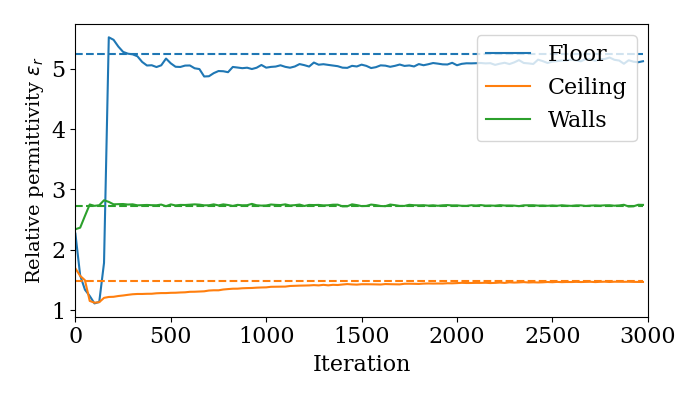

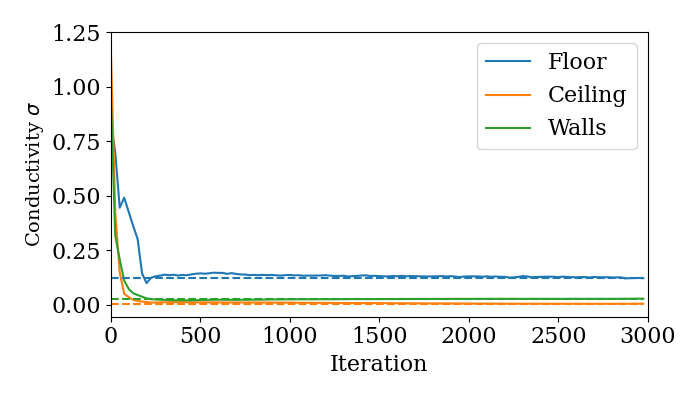

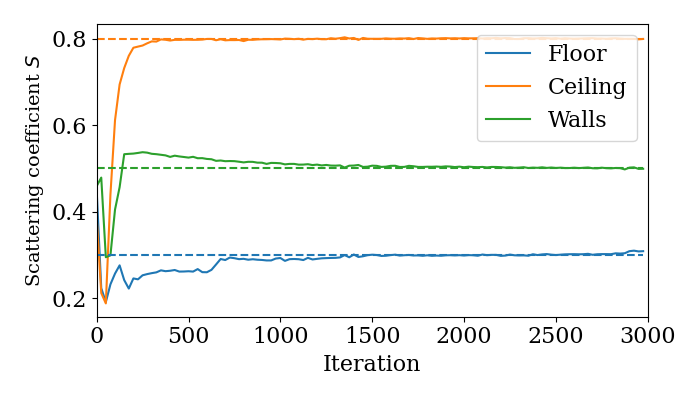

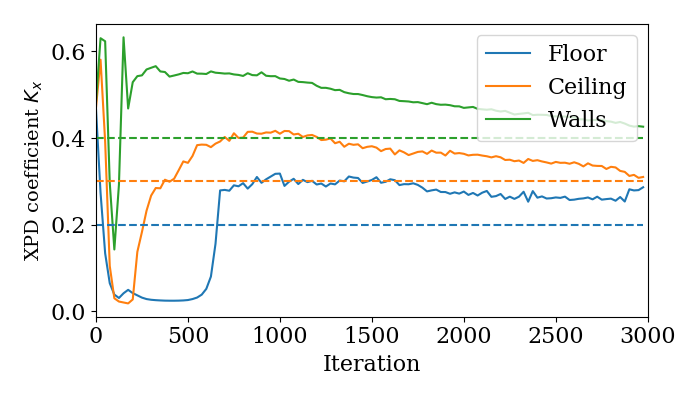

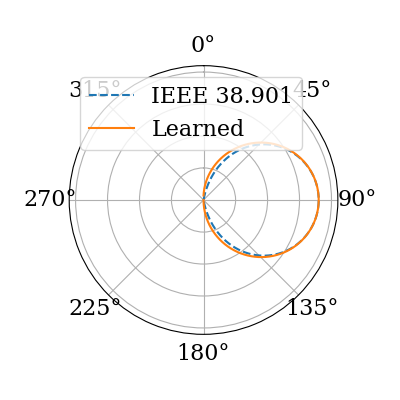

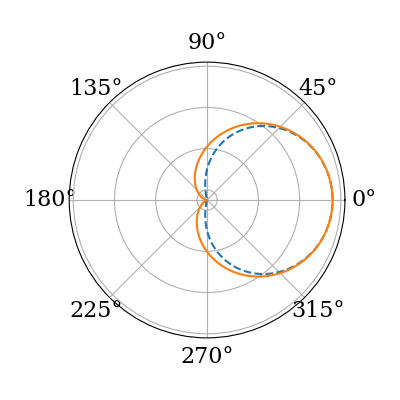

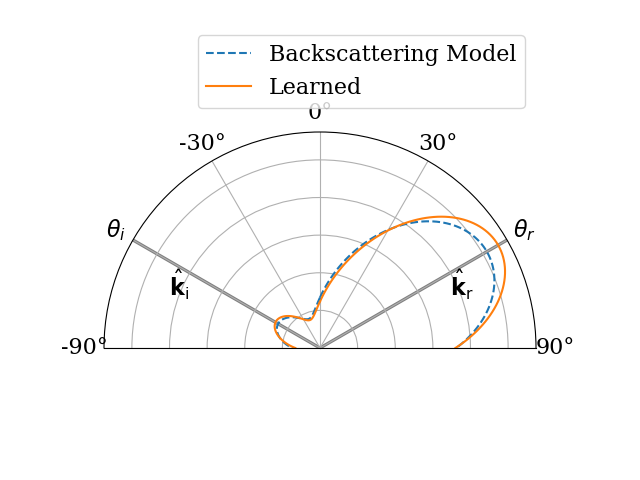

In [8]:
plot_results_synthetic_data(train_dict, ground_truth, scene, save_figs=True)
